In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cosmology import Y_x_eq # equilibrium comoving density of x particles
import h5py

import fBE_solver as fBE

Defining the physics for the tau decay to muon and axion and creating the corresponding process (and collision term). Everything here can be arbitrary and is provided by the user in their code in any manner 

In [2]:
# The mass of the mother particle (MP)
m1 = 1.776  # GeV (tau)
# The mass of the daughter particle (DP)
m2 = 0.10565  # GeV (muon)
# Ratio of the two masses
mu = m2/m1

# Number of massless particle degrees of freedom
g_x = 1.0
# Number of MP dofs
g_m1 = 2.0
# Number of DP dofs
g_m2 = 2.0

# Coupling of MP-DP-x
yMDx = 1/(4E+8) # for f_a = 1e+7 GeV

# Decay width of MP -> DP + x
Gamma = yMDx**2*m1**3*(1-mu**2)**3/64/np.pi # GeV
# Msquared for the decay
Msquared = yMDx**2*m1**4*(1 - mu**2)**2/4 # GeV^2




Creating an instance of the Model class for the axion and an instance of the particular process (decay)

In [3]:
TauDecAx = fBE.Model(m1,1,'b') # takes (m,g_a,'b' for boson); there are also some default values of x and q, check the library
# m1 = 1.776 GeV is the mass of the tau lepton, not the axion. Here it is rather the mass that enters the x = m/T relation

# Creating an instance of the DecayToX class that describes the processes of decay of one particle into a massive and massless particle
TauDecay = fBE.DecayToX(m1,m2,g_m1,Msquared,Gamma)


TauDecAx2 = fBE.Model(m1,1,'b')
#creating the second instance of the class to use the interpolation function


Defining the grid of x and q values and assigning it to the model

In [4]:
N_x = 1000 # number of x points
N_q = 200 # number of q points
xstart = 1.0  # starting x value
xfin = 20.0 # final x value

qin = 0.0001 # starting q value
qend = 20. # final q value

# Creating vectors of linearly distributed values of x and q
x_lin = np.linspace(xstart,xfin,N_x)
q_lin = np.linspace(qin,qend,N_q)

# Assigning the grid (of x and q) to the model
TauDecAx.changeGrid(x_lin,q_lin)

Now we add the collision term to our Model - that is the method of the instance of the process class "DecayToX". The idea behind "addCollisionTerm" is that we can add many collision terms created from process classes or even arbitrary functions of (x,q,f) and store them in the Model instance

In [5]:
TauDecAx.addCollisionTerm(TauDecay.collisionTerm) # collisionTerm() is the method of the class DecayToX, addCollisionTerm() is the method of the class Model

Let's create a HDF5 file with the tabulated Collision term

In [6]:
x_test=np.linspace(1,21,100)
q_test=np.linspace(0.0001,20,200)
f_test=np.linspace(0,1,100)

x_test_grid,q_test_grid,f_test_grid=np.meshgrid(x_test,q_test,f_test,indexing='ij')
result=TauDecay.collisionTerm(x_test_grid,q_test_grid,f_test_grid)


with h5py.File('example_input.hdf5', 'w') as f:
    # Create a dataset and write the data
    f.create_dataset('Collision', data=result)
    f.create_dataset('x',data=x_test)
    f.create_dataset('q',data=q_test)
    f.create_dataset('f',data=f_test)

And using a function we add the collision term from the file:

In [7]:
TauDecAx2.addUserCollisionTerm(r"example_input.hdf5",use_extrapolation=True)

Defining the initial condition for the fBE and running the solver

In [8]:
f0 = np.zeros_like(q_lin) # should be a vector of the size q
#f0 = q_lin**2/(np.exp(q_lin)-1.0) # equilibrium PDF
TauDecAx.solve_fBE(f0) # solve_fBE is the method of the class Model that solves the fBE for the given Collision Term and x and q

TauDecAx2.solve_fBE(f0)

getSolution() method gives you the resulting distribution function. Below we can check the shape of the solution array, for example

In [9]:
TauDecAx.getSolution().shape
TauDecAx2.getSolution().shape

(100, 200)

Plot a kymograph of the solution using the built-in method of the Model class

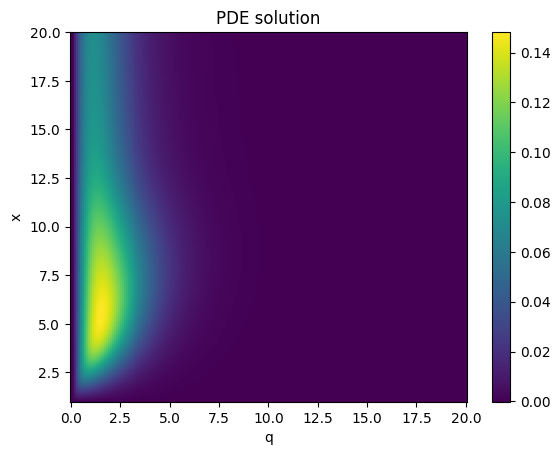

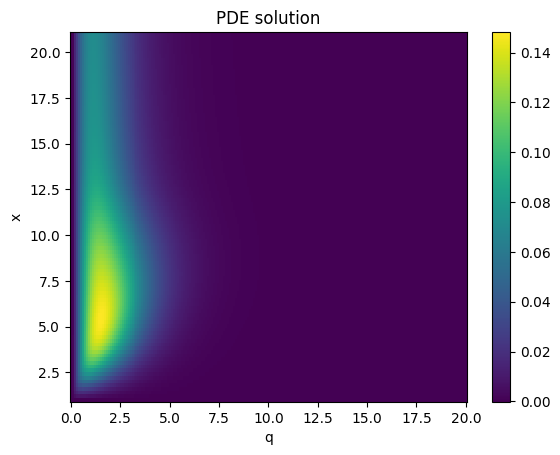

In [10]:
TauDecAx.plot2D()
TauDecAx2.plot2D()


Let's also get and plot the resulting comoving density of axions

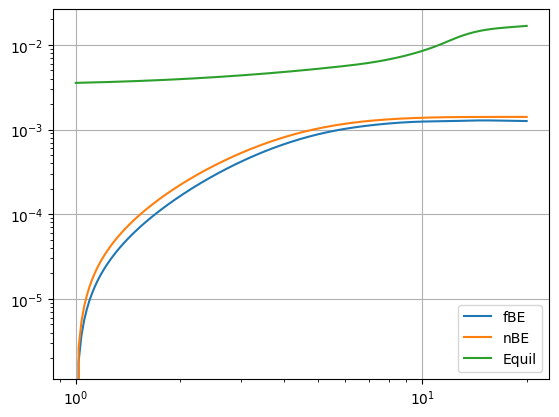

In [11]:
x = TauDecAx.getX() # returns a vector of x values
Y = TauDecAx.getDensity() # returns the corresponding (density) integral of the distrib. function

Yode = TauDecAx.solve_nBE(x,TauDecay.rate,0.0) # solve the standard Boltzmann ODE to compare the results

plt.figure
plt.loglog(x,Y)
plt.loglog(x,Yode)
plt.loglog(x,Y_x_eq(m1/x))
plt.grid()
plt.legend(["fBE", "nBE","Equil"], loc="lower right")
plt.show()

In [12]:
# Final values of the density returned by the two methods
print('Y_fbe = ',Y[-1])
print('Y_nbe = ',Yode[-1])

Y_fbe =  0.0012602109761018125
Y_nbe =  0.0014099040871598952


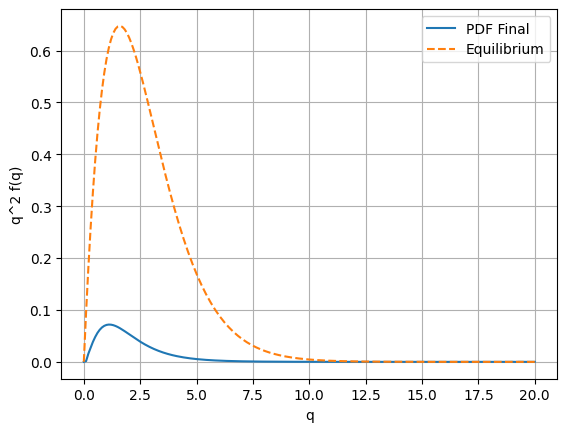

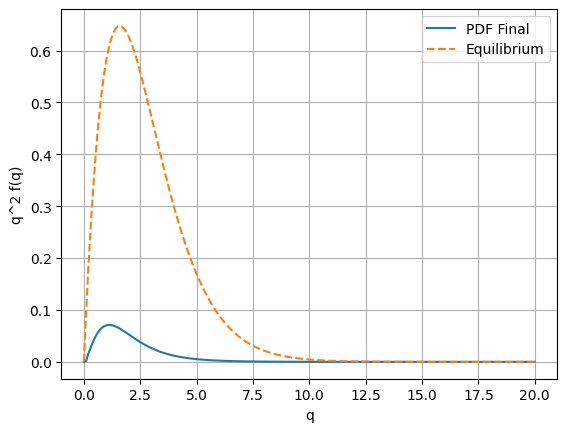

In [14]:
TauDecAx.plotFinalPDF()
TauDecAx2.plotFinalPDF()
